In [1]:
#Imports
import pandas as pd
import numpy as np
from goatools.base import get_godag
from goatools.anno.gaf_reader import GafReader
from goatools.gosubdag.gosubdag import GoSubDag
from collections import defaultdict
import pickle

In [2]:
#Get the GO terms
godag = get_godag("go-basic.obo", optional_attrs='relationship')

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms; optional_attrs(relationship)


In [3]:
#Get the GO Annotation File
gogaf = GafReader("goa_yeast.gaf")

HMS:0:00:03.290250  91,452 annotations READ: goa_yeast.gaf 


In [4]:
#Build pairs and sl columns in gene2sl
genes     = pd.read_csv('gsets_1', header=None, names=["genes"])
sl_lables = pd.read_csv('sl_1', header=None, names=["sl"])
gene2sl   = pd.concat([genes, sl_lables], axis=1)

In [5]:
#Now get a gene to GO id dict.
gene2goid = defaultdict(set)
for assoc in gogaf.associations:
    for syn in assoc.DB_Synonym:
        gene2goid[syn].add(assoc.GO_ID)

In [6]:
%%prun  
#%%time
#Now build the hierarchy, meaning each node is represented by the no. of all its descendants
genes2terms = pd.DataFrame()
gene2terms = {}
list_genes2terms = []
for index, row in gene2sl.iterrows():
    for gene in row['genes'].split("$"):
        #No such gene, build it
        if gene not in gene2terms:
            gene2terms[gene] = {}
            genebiogoid = []
            go_ids = gene2goid.get(gene)
            if go_ids is None:
                print("Could not find the gene {} in GAF".format(gene))               
            else:
                for go_id in go_ids:
                    term = godag.get(go_id)
                    if term.namespace == 'biological_process':                     
                        #Get the leaf GO term
                        genebiogoid.append(go_id)  
                        #Mark the visitation of that leaf
                        if go_id not in gene2terms[gene]:
                            gene2terms[gene][go_id] = 1
                        else:
                            gene2terms[gene][go_id] += 1
            # Create a subset of the GO DAG which contains:
            # The common GO terms that are 'is_a' for the gene, by setting relationships=False
            gosubdag = GoSubDag(genebiogoid, godag, relationships=False, prt=False) 
            ancestors = defaultdict(set)
            if go_id in gosubdag.rcntobj.go2parents:
                for p_go in gosubdag.rcntobj.go2parents[go_id]:
                    dict_anc = gosubdag.go2nt[p_go]._asdict()
                    ancestors[dict_anc['depth']].add(dict_anc['GO'])                            
            #Sum up all the ancestors values (the root is marked as depth 0)
            count_genes = 1  
            for level in range(len(ancestors) - 1, -1, -1):
                for GO in ancestors[level]:
                    if GO not in gene2terms[gene]:
                        gene2terms[gene][GO] = count_genes
                    else:
                        gene2terms[gene][GO] += count_genes                                
                count_genes += len(ancestors[level])                          
    #Build the combination of the 2 genes
    g1, g2 = row['genes'].split("$")
    gene1 = gene2terms[g1]
    gene2 = gene2terms[g2]         
    genesdict = {key: gene1.get(key, 0) + gene2.get(key, 0)
                 for key in set(gene1) | set(gene2)}
    genesdict['genes'] = row['genes']
    genesdict['sl'] = row['sl']
    list_genes2terms.append(genesdict)    

Could not find the gene YIL168W in GAF
**NOTE: 47,285 SOURCE GO IDS
Could not find the gene YIL170W in GAF
**NOTE: 47,285 SOURCE GO IDS
 

In [7]:
#Save the list for later
with open("list_genes2terms.txt", "wb") as fp:   #Pickling
    pickle.dump(list_genes2terms, fp) 

In [8]:
#Add the final data and clean NaN
genes2terms = genes2terms.append(list_genes2terms, ignore_index=True)
genes2terms = genes2terms.fillna(0)

In [10]:
#Save the DataFrame for later
genes2terms.to_pickle("genes2terms.pkl")

In [11]:
#Remove columns with no information
nunique = genes2terms.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
print("dropping {} columns".format(len(cols_to_drop)))
genes2terms.drop(cols_to_drop, axis=1)

dropping 0 columns


,GO:0071840,GO:0043486,GO:0007029,GO:0045324,GO:0006623,GO:0016192,GO:0051641,GO:0051234,GO:0006338,GO:0016043,...,GO:0010827,GO:0006106,GO:1903795,GO:0072715,GO:1903959,GO:0043269,GO:0044070,GO:0034762,GO:1901858,GO:1903710
0,3.0,1.0,1.0,2.0,1.0,5.0,9.0,9.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,2.0,1.0,5.0,9.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,2.0,1.0,5.0,9.0,9.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,2.0,1.0,5.0,9.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,2.0,1.0,5.0,9.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Load the data
genes2terms = pd.DataFrame()
genes2terms = pd.read_pickle("genes2terms.pkl")
genes2terms = genes2terms.set_index('genes')

In [10]:
#Get the standard model to which we are comparing
standard_model = pd.read_csv('all.onto_genes.features.cv_all.rf.predictions', header=None, names=["prob"])
standard_model['sl'] = -1
standard_model.loc[standard_model['prob'] >= 0.5,'sl'] = 1
standard_model.loc[standard_model['prob'] < 0.5,'sl'] = 0
standard_model['pairs'] = genes2terms.index.values
standard_model = standard_model.set_index('pairs')

In [29]:
#Get the standard model to which we are comparing
standard_model = pd.read_csv('all.onto_genes.features.cv_all.rf.predictions', header=None, names=["sl"])
#standard_model['sl'] = -1
#standard_model.loc[standard_model['prob'] >= 0.5,'sl'] = 1
#standard_model.loc[standard_model['prob'] < 0.5,'sl'] = 0
standard_model['pairs'] = genes2terms.index.values
standard_model = standard_model.set_index('pairs')
standard_auc = roc_auc_score(y, standard_model['sl'])
standard_auc

0.9178400453484316

In [32]:
standard_model

,sl
pairs,
YAL002W$YAL011W,0.000000
YAL002W$YAL013W,0.043333
YAL002W$YAL019W,0.013333
YAL002W$YAL021C,0.463333
YAL002W$YAL058W,0.006667
...,...
YPR135W$YPR159W,0.000000
YPR135W$YPR164W,0.386667
YPR141C$YPR159W,0.033333


Execute run 0
Execute run 1
Execute run 2
Execute run 3
Execute run 4


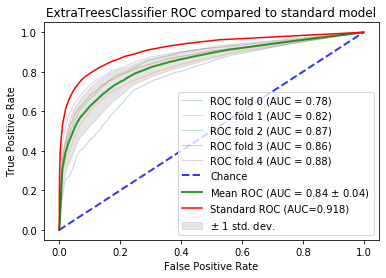

In [28]:
%matplotlib inline
## import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Set the X, y data
X = genes2terms.drop(['sl'], axis=1)
y = genes2terms['sl']
# Run classifier with cross-validation  
cv = StratifiedKFold(n_splits=5)

#classifier = LogisticRegression(solver='lbfgs', max_iter=500) #---mean AUC was 0.73 with 6 cv
#classifier = RandomForestClassifier(n_estimators=120) #-----------so far the best
#classifier = GradientBoostingClassifier(n_estimators=120) #-------mean auc 0.716 with 5 cv
#classifier = AdaBoostClassifier() #-------------------------------mean auc 0.69 with 5 cv
#classifier = GaussianNB() #---------------------------------------mean auc 0.59 with 5 cv
#classifier = QuadraticDiscriminantAnalysis() #--------------------mean auc 0.59 with 5 cv
#classifier = SGDClassifier(max_iter=1000) #-----------------------mean auc 0.65 with 5 cv
classifier = ExtraTreesClassifier(n_estimators=120)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    print("Execute run {}".format(i))
    #Fit the model
    classifier.fit(X.iloc[train], y.iloc[train])
    #Get the predictions and keep AUC values for later plot
    viz = plot_roc_curve(classifier, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
# Plot ROC curves        
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='green',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
#Now the standard model
standard_auc = roc_auc_score(y, standard_model['prob'])
base_fpr, base_tpr, _ = roc_curve(y, standard_model['prob'])
ax.plot(base_fpr, base_tpr, label=r'Standard ROC (AUC=%.3f)' % (standard_auc), color='red')
#Design of plot
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="{} ROC compared to standard model".format(classifier.__class__.__name__))
ax.legend(loc="lower right")
plt.show()    

In [27]:
mean_auc

0.6581969093802206

In [44]:
standard_auc

0.9178400453484316